In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Import necessary libraries
import pandas as pd

# Read CSV file from Google Drive
file_path = "/content/drive/My Drive/SWPPX.csv"
#Only attempting to analyze the Close value
df = pd.read_csv(file_path, parse_dates=True, index_col='Date', usecols=['Date', 'Close'])

In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [9]:
# Prepare the data for linear regression
X = df.index.to_julian_date().values.reshape(-1, 1)  # Convert date index to Julian date for linear regression
y = df['Close'].values.reshape(-1, 1)

In [10]:
# Create and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [11]:
# Predict the 'Close' values using the linear regression model
predicted_close = model.predict(X)

# Add the predicted 'Close' values as a new column in the DataFrame
df['Line_of_Best_Fit'] = predicted_close

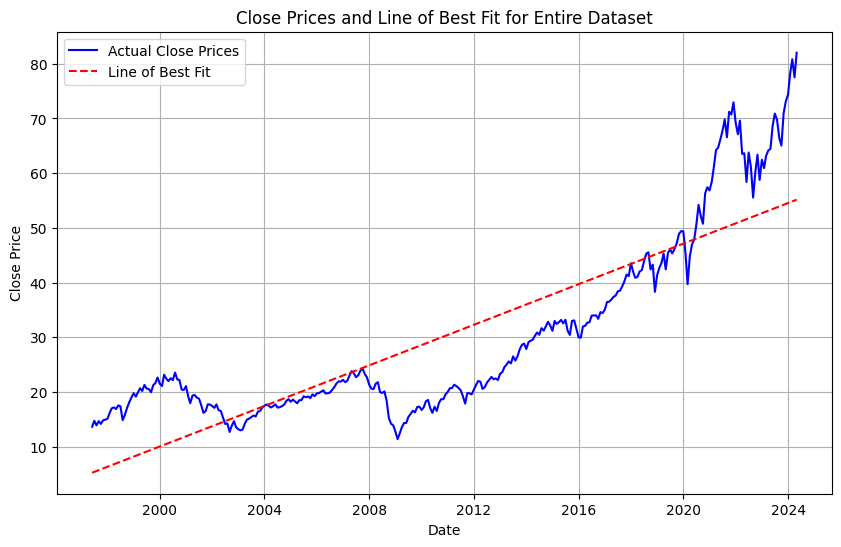

In [12]:
# Plot the data and the line of best fit for the entire dataset
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], label='Actual Close Prices', color='blue')
plt.plot(df.index, df['Line_of_Best_Fit'], label='Line of Best Fit', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Prices and Line of Best Fit for Entire Dataset')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Calculate the slope and intercept for the entire dataset
X = df.index.to_julian_date().values.reshape(-1, 1)
y = df['Close'].values.reshape(-1, 1)
slope, intercept = np.polyfit(X.flatten(), y.flatten(), 1)

In [19]:
# Select the 12th last data point
start_point_index = -12
start_date = df.index[start_point_index]
start_price = df['Close'].iloc[start_point_index]

In [20]:
# Filter data for the last 12 months from the end date
end_date = df.index[-1]
start_date_last_12_months = end_date - pd.DateOffset(months=12)
last_12_months = df[df.index >= start_date_last_12_months]

<ipython-input-21-ebf7f9aac057>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_12_months['Linear_Regression_Projected_Close'] = start_price + slope * (last_12_months.index.to_julian_date() - start_date.to_julian_date())


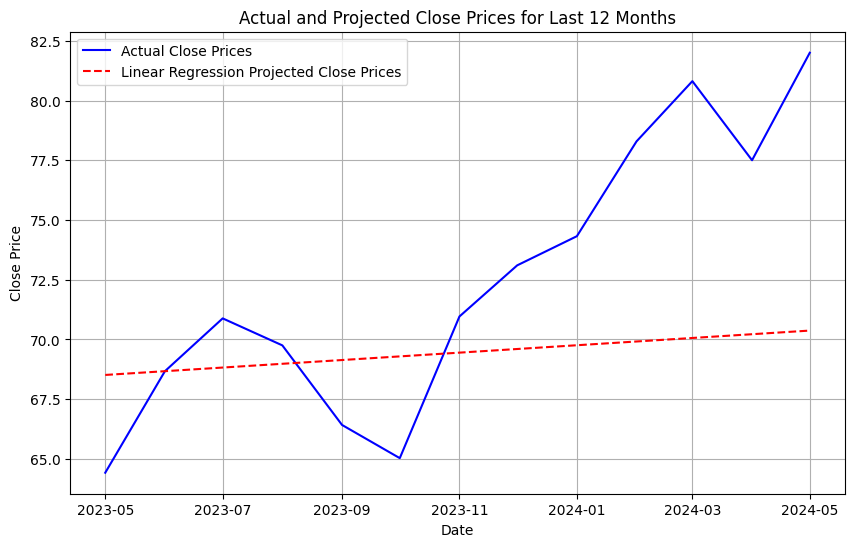

In [21]:
# Project close prices for the last 12 months using the original slope
last_12_months['Linear_Regression_Projected_Close'] = start_price + slope * (last_12_months.index.to_julian_date() - start_date.to_julian_date())

# Plot the actual close prices and the projected close prices for the last 12 months
plt.figure(figsize=(10, 6))
plt.plot(last_12_months.index, last_12_months['Close'], label='Actual Close Prices', color='blue')
plt.plot(last_12_months.index, last_12_months['Linear_Regression_Projected_Close'], label='Linear Regression Projected Close Prices', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual and Projected Close Prices for Last 12 Months')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Calculate the absolute errors
absolute_errors = np.abs(last_12_months['Close'] - last_12_months['Linear_Regression_Projected_Close'])

# Calculate the mean absolute error (MAE)
mae = np.mean(absolute_errors)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate the relative MAE
mean_actual_close = np.mean(last_12_months['Close'])
relative_mae = mae / mean_actual_close
print(f"Relative Mean Absolute Error (Relative MAE): {relative_mae}")

Mean Absolute Error (MAE): 4.7319370387754125
Relative Mean Absolute Error (Relative MAE): 0.06529234455041467


In [25]:
df.drop('Line_of_Best_Fit', axis=1, inplace=True)

In [26]:
#Now, let's try to predict the last year of the dataset using an LSTM, first we can create a train/test split
test_size=12
test_ind=len(df)-test_size
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [27]:
test

,Close
Date,
2023-06-01,68.669998
2023-07-01,70.879997
2023-08-01,69.750000
2023-09-01,66.419998
2023-10-01,65.029999
2023-11-01,70.959999
2023-12-01,73.099998
2024-01-01,74.320000
2024-02-01,78.290001


In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [29]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [30]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [31]:
# Use 6 months of historical data at a time to predict the next month
length = 6

In [32]:
generator = TimeseriesGenerator(scaled_train,scaled_train, length=length, batch_size=1)

In [33]:
X,y = generator[0]

In [34]:
X

array([[[0.03688658],
        [0.05443614],
        [0.04094897],
        [0.05329867],
        [0.04533637],
        [0.0558986 ]]])

In [35]:
y

array([[0.05768606]])

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [37]:
#Specify one feature
n_features = 1

In [38]:
#Create the model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(length, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 100)            40800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71051 (277.54 KB)
Trainable params: 71051 (277.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [66]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss')
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)
model.fit_generator(generator,epochs=6, validation_data=validation_generator)

Epoch 1/6
  7/306 [..............................] - ETA: 2s - loss: 0.0130

<ipython-input-66-fdaf2eb0c830>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=6, validation_data=validation_generator)


306/306 [==============================] - 3s 11ms/step - loss: 0.0230 - val_loss: 0.0452
Epoch 2/6
306/306 [==============================] - 3s 10ms/step - loss: 0.0226 - val_loss: 0.0671
Epoch 3/6
306/306 [==============================] - 4s 14ms/step - loss: 0.0220 - val_loss: 0.0282
Epoch 4/6
306/306 [==============================] - 4s 14ms/step - loss: 0.0246 - val_loss: 0.1294
Epoch 5/6
306/306 [==============================] - 3s 11ms/step - loss: 0.0229 - val_loss: 0.0540
Epoch 6/6
306/306 [==============================] - 5s 15ms/step - loss: 0.0205 - val_loss: 0.0477


In [67]:
losses = pd.DataFrame(model.history.history)

<Axes: >

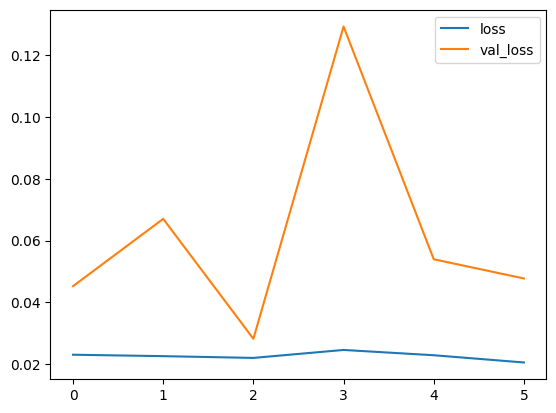

In [68]:
losses.plot()

In [69]:
#Create a prediction on the last 12 months that we already know the results of
test_preds = []
first_eval_batch = scaled_train[-length:]
curr_batch = first_eval_batch.reshape((1,length,n_features))
for i in range(len(test)):
  curr_pred = model.predict(curr_batch)[0]
  test_preds.append(curr_pred)
  curr_batch = np.append(curr_batch[:,1:,:],[[curr_pred]],axis=1)

1/1 [==============================] - 0s 23ms/step


In [70]:
true_preds = scaler.inverse_transform(test_preds)

In [71]:
test['Predictions']=true_preds

<ipython-input-71-7bbea6245e38>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions']=true_preds


In [72]:
test

,Close,Predictions
Date,,
2023-06-01,68.669998,65.835761
2023-07-01,70.879997,66.876675
2023-08-01,69.750000,67.892932
2023-09-01,66.419998,68.889605
2023-10-01,65.029999,69.806194
2023-11-01,70.959999,70.665703
2023-12-01,73.099998,71.475870
2024-01-01,74.320000,72.224989
2024-02-01,78.290001,72.915822


In [73]:
# Calculate MAE
mae = (test['Close'] - test['Predictions']).abs().mean()
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 3.611531586148749


In [74]:
test_mean = test['Close'].mean()
mae_to_avg_price = mae/test_mean
mae_to_avg_price #Determine the relative error of the predictions (About 4.9%), significantly better than the relative error of the line of best fit (6.5%)

0.04937552507751961

<Axes: xlabel='Date'>

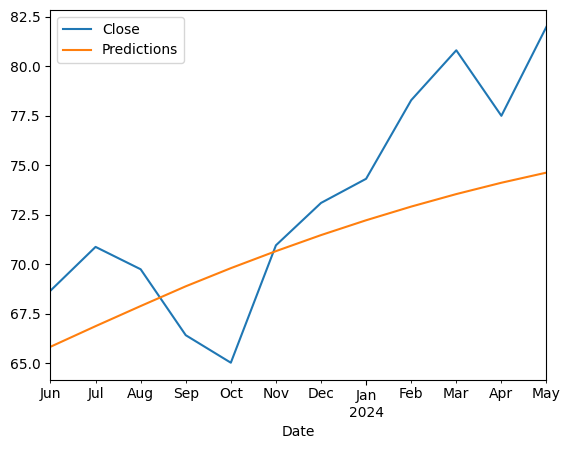

In [75]:
test.plot() #Plot the predictions compared to the actual close values

In [99]:
#Now we will try to predict the next year of data by processing the entire dataset as training data, and not having a test set
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [100]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(length, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 6, 100)            40800     
                                                                 
 lstm_7 (LSTM)               (None, 50)                30200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71051 (277.54 KB)
Trainable params: 71051 (277.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [110]:
#Using an amount of epochs based on previous training
model.fit_generator(generator,epochs=5)

Epoch 1/5
  1/318 [..............................] - ETA: 13s - loss: 0.0030

<ipython-input-110-86233c0083f8>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=5)


318/318 [==============================] - 6s 19ms/step - loss: 0.0270
Epoch 2/5
318/318 [==============================] - 3s 10ms/step - loss: 0.0255
Epoch 3/5
318/318 [==============================] - 4s 13ms/step - loss: 0.0261
Epoch 4/5
318/318 [==============================] - 5s 16ms/step - loss: 0.0263
Epoch 5/5
318/318 [==============================] - 3s 10ms/step - loss: 0.0247


In [111]:
#Determine the forecast
forecast = []
periods = 12
first_eval_batch = scaled_train[-length:]
curr_batch = first_eval_batch.reshape((1,length,n_features))
for i in range(periods):
  curr_pred = model.predict(curr_batch)[0]
  forecast.append(curr_pred)
  curr_batch = np.append(curr_batch[:,1:,:],[[curr_pred]],axis=1)

1/1 [==============================] - 0s 25ms/step


In [112]:
forecast = scaler.inverse_transform(forecast)

In [113]:
df

,Close
Date,
1997-06-01,13.670000
1997-07-01,14.750000
1997-08-01,13.920000
1997-09-01,14.680000
1997-10-01,14.190000
...,...
2024-01-01,74.320000
2024-02-01,78.290001
2024-03-01,80.809998


In [114]:
forecast

array([[67.4070596 ],
       [69.1821597 ],
       [70.88607356],
       [72.81412118],
       [74.74885201],
       [76.8814092 ],
       [79.32865744],
       [81.81116317],
       [84.46381599],
       [87.29481772],
       [90.34002005],
       [93.64119498]])

In [115]:
#Create a forecast index for every month we made a prediction on
forecast_index = pd.date_range(start = '2024-06-01', periods = periods, freq = "MS")

In [116]:
#Create a forecast dataframe using the forecasts and the created forecast index
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [117]:
forecast_df

,Forecast
2024-06-01,67.407060
2024-07-01,69.182160
2024-08-01,70.886074
2024-09-01,72.814121
2024-10-01,74.748852
2024-11-01,76.881409
2024-12-01,79.328657
2025-01-01,81.811163
2025-02-01,84.463816
2025-03-01,87.294818


(544.0, 664.0)

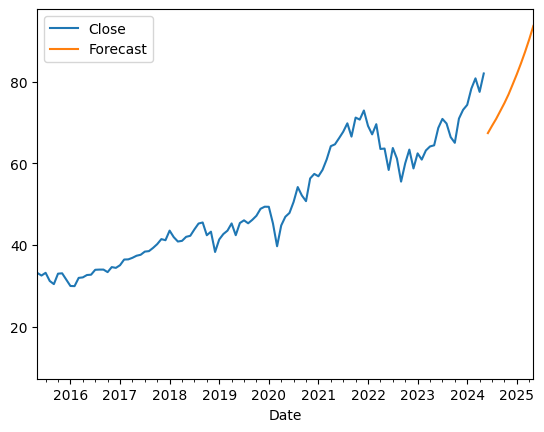

In [118]:
#Plot the original graph, and the forecast
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2015-05-01','2025-05-01')